[*********************100%%**********************]  1 of 1 completed

Using device: cuda


Epoch [10/100], Loss: 0.0378
Epoch [20/100], Loss: 0.0159
Epoch [30/100], Loss: 0.0091
Epoch [40/100], Loss: 0.0066
Epoch [50/100], Loss: 0.0053
Epoch [60/100], Loss: 0.0044
Epoch [70/100], Loss: 0.0033
Epoch [80/100], Loss: 0.0025
Epoch [90/100], Loss: 0.0021
Epoch [100/100], Loss: 0.0019


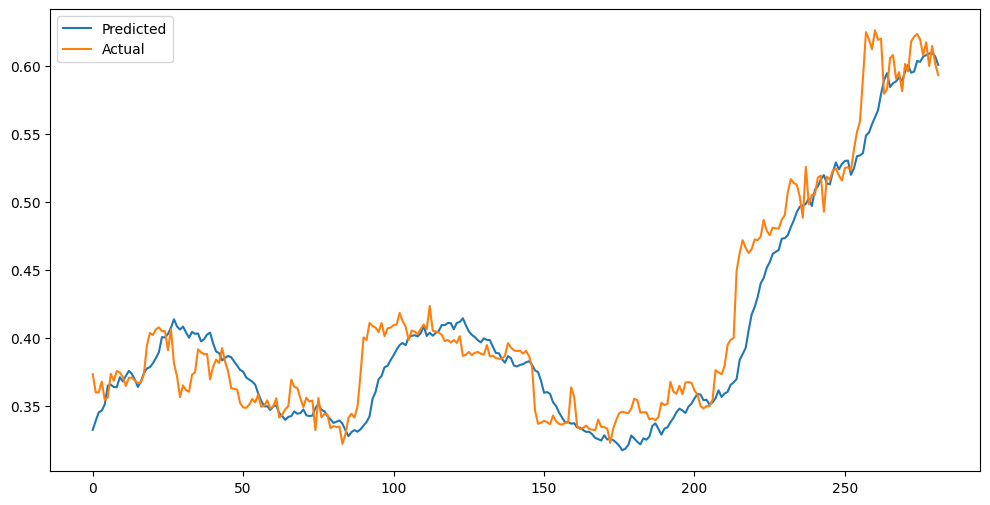

In [11]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from textblob import TextBlob

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to fetch historical Bitcoin price data
def fetch_price_data(symbol='BTC-USD', start_date='2020-01-01', end_date='2023-12-31'):
    df = yf.download(symbol, start=start_date, end=end_date, interval='1d')
    df['Sentiment'] = 0
    return df

# Function to fetch tweets and analyze sentiment
def fetch_tweets_and_analyze_sentiment(date):
    # Placeholder: Replace with actual method to fetch tweets from a free source
    tweets = [
        "Bitcoin is doing great!",
        "Bitcoin prices are falling.",
        "It's a good time to invest in Bitcoin.",
    ]
    
    # Analyze sentiment using TextBlob
    sentiments = [TextBlob(tweet).sentiment.polarity for tweet in tweets]
    average_sentiment = np.mean(sentiments) if sentiments else 0
    return average_sentiment

# Function to update sentiment data in price data
def update_sentiment_data(df):
    sentiments = []
    for date in df.index:
        daily_sentiment = fetch_tweets_and_analyze_sentiment(date)
        sentiments.append(daily_sentiment)
    df['Sentiment'] = sentiments
    return df

# Preprocess data
def preprocess_data(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['Close', 'Volume', 'Sentiment']])
    return scaled_data, scaler

# Define the Q-Network
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize environment and parameters
def initialize_environment(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length - 1):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length][0])  # Use the closing price as target
    return np.array(X), np.array(y)

# Train the model
def train_model(X_train, y_train, model, criterion, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        inputs = torch.tensor(X_train, dtype=torch.float32).to(device)
        targets = torch.tensor(y_train, dtype=torch.float32).to(device).unsqueeze(1)  # Make targets 2D
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Main function to run the training process
def main():
    symbol = 'BTC-USD'
    start_date = '2020-01-01'
    end_date = '2023-12-31'
    seq_length = 50
    
    # Fetch and prepare data
    price_data = fetch_price_data(symbol, start_date, end_date)
    sentiment_data = update_sentiment_data(price_data)
    processed_data, scaler = preprocess_data(sentiment_data)
    
    # Initialize environment
    X, y = initialize_environment(processed_data, seq_length)
    X_train, X_test = X[:int(len(X) * 0.8)], X[int(len(X) * 0.8):]
    y_train, y_test = y[:int(len(y) * 0.8)], y[int(len(y) * 0.8):]
    
    # Define model, criterion, and optimizer
    input_dim = X_train.shape[1] * X_train.shape[2]
    model = QNetwork(input_dim=input_dim, output_dim=1).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Reshape X_train and X_test to match input dimensions
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    
    # Train model
    train_model(X_train, y_train, model, criterion, optimizer, num_epochs=100)
    
    # Evaluate model
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X_test, dtype=torch.float32).to(device)
        predictions = model(inputs).cpu().numpy()
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(predictions, label='Predicted')
    plt.plot(y_test, label='Actual')
    plt.legend()
    plt.show()

# Run the main function
if __name__ == '__main__':
    main()
